# <span style="color:darkred"> **SI670 FINAL PROJECT** </span>  
## <span style="color:black"> **DATASET: SENTINAL LAKES TEMPERATURES** </span> 
### <span style="color:BLACK"> **HYPOTHESIS: Given the scenario of global warming, we assume that temperatures of the water bodies have decreased over the years.** </span> 

# <span style="color:darkblue"> **Libraries** </span>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

In [2]:
trout_train = pd.read_csv('Trout_training.csv')
trout_test = pd.read_csv('Trout_testing_features.csv')

In [3]:
trout_train.shape

(839215, 3)

In [4]:
trout_test.shape

(131400, 3)

# <span style="color:darkblue"> **Data Exploration** </span>

In [5]:
trout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839215 entries, 0 to 839214
Data columns (total 3 columns):
Date_Time       839215 non-null object
Water_Temp_C    839215 non-null float64
Depth_m         839215 non-null float64
dtypes: float64(2), object(1)
memory usage: 19.2+ MB


In [6]:
trout_train.describe()

,Water_Temp_C,Depth_m
count,839215.000000,839215.000000
mean,6.336614,9.628875
std,5.591335,5.557104
min,0.273000,1.500000
25%,1.994000,4.500000
50%,5.050000,9.500000
75%,8.245000,14.500000
max,25.768000,20.500000


# <span style="color:darkblue"> **Data Pre-Processing** </span>

In [7]:
trout_train['year'] = pd.Series([str(i[0:4]) for i in trout_train['Date_Time']])
trout_train['month'] = pd.Series([str(i[5:7]) for i in trout_train['Date_Time']])
trout_train['date'] = pd.Series([str(i[8:10]) for i in trout_train['Date_Time']])
trout_train['time'] = pd.Series([int(i[11:13]) for i in trout_train['Date_Time']])
trout_train['Date'] =  trout_train['date'] + '-' + trout_train['month'] + '-' + trout_train['year']
# trout_train['full_date'] =  pd.Series([str(i[0:10]) for i in trout_train['Date_Time']])

In [8]:
trout_test['year'] = pd.Series([str(i[0:4]) for i in trout_test['Date_Time']])
trout_test['month'] = pd.Series([str(i[5:7]) for i in trout_test['Date_Time']])
trout_test['date'] = pd.Series([str(i[8:10]) for i in trout_test['Date_Time']])
trout_test['time'] = pd.Series([int(i[11:13]) for i in trout_test['Date_Time']])
trout_test['Date'] =  trout_test['date'] + '-' + trout_test['month'] + '-' + trout_test['year']

In [9]:
del trout_train['Date_Time']
del trout_test['Date_Time']
# del trout_train['date']
# del trout_train['year']
# del trout_train['month']

In [10]:
trout_train.head()

,Water_Temp_C,Depth_m,year,month,date,time,Date
0,5.257,1.5,2012,04,20,0,20-04-2012
1,5.257,2.5,2012,04,20,0,20-04-2012
2,5.257,3.5,2012,04,20,0,20-04-2012
3,5.205,4.5,2012,04,20,0,20-04-2012
4,5.205,5.5,2012,04,20,0,20-04-2012


In [11]:
trout_test.head()

,Water_Temp_C,Depth_m,year,month,date,time,Date
0,0.412,1.5,2018,04,20,0,20-04-2018
1,0.852,2.5,2018,04,20,0,20-04-2018
2,0.907,3.5,2018,04,20,0,20-04-2018
3,0.962,4.5,2018,04,20,0,20-04-2018
4,1.071,5.5,2018,04,20,0,20-04-2018


In [12]:
unique_dates = list(trout_train['Date'].unique())
unique_time = list(trout_train['time'].unique())
trout_train['Water_Temp_C'] = trout_train['Water_Temp_C'].apply(lambda x: round(x, 2))
trout_train['Depth_m'] = trout_train['Depth_m'].apply(lambda x: round(x, 1))
trout_test['Water_Temp_C'] = trout_test['Water_Temp_C'].apply(lambda x: round(x, 2))
trout_test['Depth_m'] = trout_test['Depth_m'].apply(lambda x: round(x, 1))
print(len(unique_time))
print(len(unique_dates))

24
2191


In [13]:
for a in unique_time:
    trout_train[a] = 0

trout_train.head()

,Water_Temp_C,Depth_m,year,month,date,time,Date,0,1,2,...,14,15,16,17,18,19,20,21,22,23
0,5.26,1.5,2012,04,20,0,20-04-2012,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.26,2.5,2012,04,20,0,20-04-2012,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.26,3.5,2012,04,20,0,20-04-2012,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.21,4.5,2012,04,20,0,20-04-2012,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.21,5.5,2012,04,20,0,20-04-2012,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
for c in unique_time:
    trout_test[c] = 0

trout_test.head()

,Water_Temp_C,Depth_m,year,month,date,time,Date,0,1,2,...,14,15,16,17,18,19,20,21,22,23
0,0.41,1.5,2018,04,20,0,20-04-2018,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.85,2.5,2018,04,20,0,20-04-2018,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.91,3.5,2018,04,20,0,20-04-2018,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.96,4.5,2018,04,20,0,20-04-2018,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.07,5.5,2018,04,20,0,20-04-2018,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
trout_refine = trout_train.copy()
del trout_refine['time']
del trout_refine['Water_Temp_C']
del trout_refine['Depth_m']
# del trout_refine['month']
# del trout_refine['date']

In [16]:
trout_test_refine = trout_test.copy()
del trout_test_refine['time']
del trout_test_refine['Water_Temp_C']
del trout_test_refine['Depth_m']

In [17]:
trout_refined = trout_refine.drop_duplicates()
# del trout_refined['year']
trout_ready = trout_refined.reset_index()
del trout_ready['index']

In [18]:
trout_test_refined = trout_test_refine.drop_duplicates()
trout_test_ready = trout_test_refined.reset_index()
del trout_test_ready['index']

In [19]:
trout_ready

,year,month,date,Date,0,1,2,3,4,5,...,14,15,16,17,18,19,20,21,22,23
0,2012,04,20,20-04-2012,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012,04,21,21-04-2012,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012,04,22,22-04-2012,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012,04,23,23-04-2012,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012,04,24,24-04-2012,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,2018,04,15,15-04-2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2187,2018,04,16,16-04-2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2188,2018,04,17,17-04-2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2189,2018,04,18,18-04-2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
trout_test_ready

,year,month,date,Date,0,1,2,3,4,5,...,14,15,16,17,18,19,20,21,22,23
0,2018,04,20,20-04-2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018,04,21,21-04-2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018,04,22,22-04-2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2018,04,23,23-04-2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2018,04,24,24-04-2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019,04,15,15-04-2019,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
361,2019,04,16,16-04-2019,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
362,2019,04,17,17-04-2019,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
363,2019,04,18,18-04-2019,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# trout_date= list(trout_ready['Date'])
# trout_time= list(trout_train['time'])
# trout_temp= list(trout_train['Water_Temp_C'])
# trout_depth= list(trout_train['Depth_m'])

In [21]:
t =-1
listoflist=[]

while t < 23:
    t=t+1
    per_time_list = []
    trout = trout_train[trout_train.time == t]
    for x in unique_dates:
        df = trout[ trout['Date'] == x ]
        temp_list = list(df['Water_Temp_C'])
        if len(temp_list) > 0:
            avg_per_day_temp = sum(temp_list)/len(temp_list)
            per_time_list.append(avg_per_day_temp) 
        else:
            per_time_list.append(0)
    listoflist.append(per_time_list)

In [22]:
t =-1
listoflisttest=[]
test_dates = list(trout_test_ready['Date'].unique())
while t < 23:
    t=t+1
    per_time_list_t = []
    trout_test = trout_test[trout_test.time == t]
    for x in test_dates:
        df_test = trout_test[ trout_test['Date'] == x ]
        temp_list_test = list(df_test['Water_Temp_C'])
        if len(temp_list_test) > 0:
            avg_per_day_temp_test = sum(temp_list_test)/len(temp_list_test)
            per_time_list_t.append(avg_per_day_temp_test) 
        else:
            per_time_list_t.append(0)
    listoflisttest.append(per_time_list_t)

In [23]:
for x in range(len(listoflisttest)):
#     if x < len(listoflisttest):
    trout_test_ready[x] = listoflisttest[x]
    trout_test_ready[x] = trout_test_ready[x].apply(lambda a: round(a, 2))
# print(listoflisttest[0])

In [24]:
for x in range(len(listoflist)):
#     if x+1 < len(listoflist):
    trout_ready[x] = listoflist[x]
    trout_ready[x] = trout_ready[x].apply(lambda a: round(a, 2))

In [25]:
trout_ready['Average_Temperature_Day'] = trout_ready.iloc[:, -25:-1].sum(axis=1)
trout_ready

,year,month,date,Date,0,1,2,3,4,5,...,15,16,17,18,19,20,21,22,23,Average_Temperature_Day
0,2012,04,20,20-04-2012,5.04,5.02,4.98,4.98,4.97,4.94,...,4.93,4.92,4.91,4.91,4.93,4.93,4.98,5.05,5.02,113.55
1,2012,04,21,21-04-2012,5.06,5.06,5.06,5.03,5.04,5.02,...,4.99,5.00,4.99,5.05,5.11,5.11,5.12,5.13,5.10,115.73
2,2012,04,22,22-04-2012,5.11,5.12,5.09,5.10,5.06,5.04,...,5.03,5.07,5.11,5.09,5.08,5.18,5.23,5.26,5.24,116.58
3,2012,04,23,23-04-2012,5.29,5.26,5.24,5.23,5.23,5.21,...,5.29,5.29,5.30,5.31,5.35,5.38,5.38,5.38,5.44,121.27
4,2012,04,24,24-04-2012,5.51,5.51,5.50,5.58,5.63,5.63,...,5.57,5.65,5.67,5.71,5.77,5.83,5.86,5.85,5.82,129.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,2018,04,15,15-04-2018,1.36,1.36,1.36,1.36,1.36,1.36,...,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,31.27
2187,2018,04,16,16-04-2018,1.36,1.36,1.36,1.36,1.36,1.36,...,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,31.28
2188,2018,04,17,17-04-2018,1.36,1.36,1.36,1.36,1.36,1.36,...,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,31.28
2189,2018,04,18,18-04-2018,1.36,1.36,1.36,1.36,1.36,1.36,...,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,31.28


In [26]:
trout_test_ready['Average_Temperature_Day'] = trout_test_ready.iloc[:, -25:-1].sum(axis=1)
trout_test_ready

,year,month,date,Date,0,1,2,3,4,5,...,15,16,17,18,19,20,21,22,23,Average_Temperature_Day
0,2018,04,20,20-04-2018,1.37,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.37
1,2018,04,21,21-04-2018,1.38,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.38
2,2018,04,22,22-04-2018,1.40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.40
3,2018,04,23,23-04-2018,1.45,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.45
4,2018,04,24,24-04-2018,1.52,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019,04,15,15-04-2019,3.53,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.53
361,2019,04,16,16-04-2019,3.54,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.54
362,2019,04,17,17-04-2019,3.55,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.55
363,2019,04,18,18-04-2019,3.55,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.55


In [27]:
trout_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 29 columns):
year                       2191 non-null object
month                      2191 non-null object
date                       2191 non-null object
Date                       2191 non-null object
0                          2191 non-null float64
1                          2191 non-null float64
2                          2191 non-null float64
3                          2191 non-null float64
4                          2191 non-null float64
5                          2191 non-null float64
6                          2191 non-null float64
7                          2191 non-null float64
8                          2191 non-null float64
9                          2191 non-null float64
10                         2191 non-null float64
11                         2191 non-null float64
12                         2191 non-null float64
13                         2191 non-null float64
14             

In [28]:
trout_ready.describe()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Average_Temperature_Day
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,...,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,6.353857,6.346143,6.340151,6.337010,6.336508,6.332241,6.329375,6.328969,6.323423,6.318403,...,6.321867,6.326550,6.328179,6.336016,6.344044,6.355869,6.361534,6.362369,6.360128,145.646860
std,4.517972,4.510766,4.505630,4.504122,4.505087,4.501417,4.495792,4.490381,4.484708,4.480741,...,4.484149,4.489611,4.496227,4.502411,4.510006,4.520273,4.525897,4.526976,4.525575,103.402267
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.440000,0.440000,0.430000,...,0.460000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.470000
25%,1.970000,1.975000,1.975000,1.975000,1.970000,1.970000,1.970000,1.970000,1.970000,1.975000,...,1.975000,1.970000,1.970000,1.970000,1.970000,1.970000,1.970000,1.970000,1.975000,45.360000
50%,5.700000,5.690000,5.680000,5.650000,5.630000,5.610000,5.570000,5.540000,5.550000,5.540000,...,5.540000,5.540000,5.550000,5.590000,5.640000,5.720000,5.730000,5.720000,5.720000,128.700000
75%,10.850000,10.835000,10.810000,10.810000,10.805000,10.810000,10.790000,10.780000,10.785000,10.760000,...,10.775000,10.790000,10.810000,10.835000,10.855000,10.870000,10.890000,10.880000,10.880000,248.195000
max,14.150000,14.220000,14.130000,14.120000,14.140000,14.150000,14.130000,14.200000,14.090000,14.110000,...,14.080000,14.190000,14.140000,14.150000,14.240000,14.280000,14.160000,14.190000,14.220000,323.780000


# <span style="color:darkblue"> **Data Analysis** </span>

In [29]:
trout_corr1 = trout_ready.copy()
trout_corr_data1 = trout_corr1.loc[(trout_corr1['month'] == '05') & (trout_corr1['year'] == '2012')]
trout_corr_data2 = trout_corr1.loc[(trout_corr1['month'] == '05') & (trout_corr1['year'] == '2016')]
del trout_corr_data1['date']
del trout_corr_data1['month']
del trout_corr_data1['year']
del trout_corr_data2['date']
del trout_corr_data2['month']
del trout_corr_data2['year']
# trout_corr = trout_corr2.set_index(['Date'])

In [30]:
trout_corr_data1.describe()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Average_Temperature_Day
count,31.00000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,...,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,8.59129,8.549355,8.519355,8.495161,8.493226,8.509032,8.528065,8.515484,8.499677,8.497097,...,8.537419,8.566129,8.599355,8.623871,8.623871,8.668387,8.704194,8.723548,8.735806,196.773226
std,1.25365,1.235127,1.233294,1.220325,1.223292,1.238454,1.255360,1.243538,1.235439,1.231837,...,1.251591,1.250905,1.245857,1.238089,1.222344,1.229648,1.218104,1.201994,1.216820,28.340405
min,6.31000,6.260000,6.230000,6.240000,6.310000,6.320000,6.280000,6.290000,6.330000,6.350000,...,6.440000,6.440000,6.490000,6.480000,6.500000,6.450000,6.400000,6.400000,6.360000,147.230000
25%,7.27500,7.250000,7.285000,7.285000,7.305000,7.310000,7.315000,7.315000,7.300000,7.310000,...,7.330000,7.310000,7.295000,7.330000,7.360000,7.380000,7.430000,7.510000,7.530000,168.155000
50%,8.99000,8.950000,8.940000,8.880000,8.790000,8.820000,8.820000,8.860000,8.870000,8.800000,...,8.960000,8.910000,8.940000,8.970000,8.960000,8.970000,8.960000,9.080000,9.040000,203.790000
75%,9.76500,9.660000,9.585000,9.560000,9.625000,9.660000,9.690000,9.690000,9.575000,9.570000,...,9.670000,9.680000,9.705000,9.650000,9.605000,9.645000,9.650000,9.700000,9.785000,222.005000
max,10.05000,10.010000,10.050000,10.070000,10.050000,10.020000,10.000000,10.030000,10.080000,10.080000,...,10.020000,10.050000,10.120000,10.100000,10.030000,10.190000,10.310000,10.230000,10.120000,231.050000


In [31]:
trout_corr_data2.describe()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Average_Temperature_Day
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,...,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,6.472903,6.468710,6.451290,6.456774,6.450323,6.440968,6.424516,6.417419,6.431290,6.444516,...,6.485161,6.497419,6.521290,6.545484,6.572258,6.607742,6.626129,6.637419,6.661613,149.214194
std,1.809820,1.788524,1.752407,1.759275,1.760158,1.746763,1.724405,1.715012,1.731248,1.751184,...,1.759323,1.756312,1.744593,1.751686,1.741639,1.760276,1.761537,1.750194,1.763294,40.239605
min,3.060000,3.080000,3.090000,3.110000,3.100000,3.090000,3.080000,3.090000,3.090000,3.090000,...,3.150000,3.170000,3.180000,3.170000,3.210000,3.230000,3.240000,3.250000,3.250000,72.040000
25%,5.500000,5.480000,5.480000,5.450000,5.450000,5.450000,5.420000,5.435000,5.415000,5.400000,...,5.385000,5.415000,5.420000,5.475000,5.510000,5.555000,5.570000,5.565000,5.545000,125.315000
50%,6.670000,6.690000,6.710000,6.660000,6.630000,6.630000,6.620000,6.610000,6.580000,6.580000,...,6.600000,6.600000,6.600000,6.630000,6.640000,6.670000,6.750000,6.780000,6.810000,152.480000
75%,8.065000,7.930000,7.875000,7.990000,8.085000,7.940000,7.930000,7.920000,7.810000,7.915000,...,8.025000,8.050000,8.110000,8.125000,8.125000,8.165000,8.225000,8.110000,8.155000,186.395000
max,9.190000,8.930000,8.830000,8.820000,8.810000,8.810000,8.810000,8.990000,8.940000,8.860000,...,9.220000,9.180000,9.020000,8.950000,8.940000,9.300000,9.280000,8.980000,9.420000,203.550000


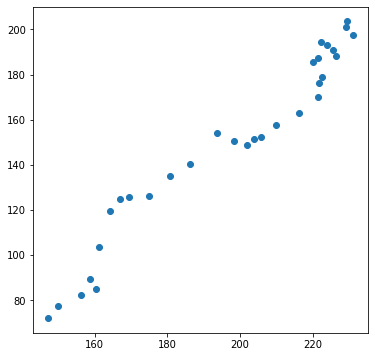

In [32]:
scat_data_1 = trout_corr_data1.copy()
scat_data1 = scat_data_1.set_index(['Date'])
scat_data1_v = scat_data1[['Average_Temperature_Day']]
scat_data_2 = trout_corr_data2.copy()
scat_data2 = scat_data_2.set_index(['Date'])
scat_data2_v = scat_data2[['Average_Temperature_Day']]

plt.figure(figsize=(6, 6))
plt.scatter(scat_data1_v, scat_data2_v)
plt.show()

In [33]:
from numpy import cov
v1 = list(scat_data1_v['Average_Temperature_Day'])
v1_array = scat_data1_v['Average_Temperature_Day'].to_numpy()
v2 = list(scat_data2_v['Average_Temperature_Day'])
v2_array = scat_data2_v['Average_Temperature_Day'].to_numpy()
V = np.stack((v1, v2), axis=0)
covariance = cov(V)
correlation = np.corrcoef(v1_array, v2_array)
print('Covariance:', covariance)
print('Correlation:', correlation)

Covariance: [[ 803.17855591 1110.53577269]
 [1110.53577269 1619.22584516]]
Correlation: [[1.         0.97380676]
 [0.97380676 1.        ]]


In [34]:
import scipy.stats
p_corr,_ = scipy.stats.pearsonr(v1_array, v2_array)
print("Pearson's correlation: %.3f" % p_corr)

Pearson's correlation: 0.974


In [35]:
dataset = trout_ready.copy()
# analysis_dataset = dataset.rename(columns={"Date": "Time"})
dataset['date_month'] = dataset['date'] + '-' + dataset['month']
unique_years = list(dataset['year'].unique())
analysis_dataset1 = dataset.drop(['month', 'date', 'Date'], axis = 1)
for e in unique_years:
    analysis_dataset1[e] = 0
analysis_dataset2 = analysis_dataset1[['date_month', '2012', '2013', '2014', '2015', '2016', '2017', '2018']]
analysis_dataset3 = analysis_dataset1[['year', 'date_month', 'Average_Temperature_Day']]
analysis_dataset = analysis_dataset2.drop_duplicates().reset_index()
del analysis_dataset['index']
analysis_dataset

,date_month,2012,2013,2014,2015,2016,2017,2018
0,20-04,0,0,0,0,0,0,0
1,21-04,0,0,0,0,0,0,0
2,22-04,0,0,0,0,0,0,0
3,23-04,0,0,0,0,0,0,0
4,24-04,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
361,16-04,0,0,0,0,0,0,0
362,17-04,0,0,0,0,0,0,0
363,18-04,0,0,0,0,0,0,0
364,19-04,0,0,0,0,0,0,0


In [36]:
d_m = list(analysis_dataset['date_month'])
list_list = []
d = 2011

while d < 2018:
    per_list = []
    d=d+1
    ddf = analysis_dataset3[analysis_dataset3.year == str(d)]
    for y in d_m:
        df = ddf[ ddf['date_month'] == y ]
        if len(df)!= 0:
            temp = list(df['Average_Temperature_Day'])
            per_list.append(temp[0]) 
        else:
            per_list.append(0)
    list_list.append(per_list)    

In [37]:
analysis_dataset['2012'] = list_list[0]
analysis_dataset['2013'] = list_list[1]
analysis_dataset['2014'] = list_list[2]
analysis_dataset['2015'] = list_list[3]
analysis_dataset['2016'] = list_list[4]
analysis_dataset['2017'] = list_list[5]
analysis_dataset['2018'] = list_list[6]

In [38]:
analysis_dataset_train = analysis_dataset.set_index(['date_month'])
analysis_dataset_train

,2012,2013,2014,2015,2016,2017,2018
date_month,,,,,,,
20-04,113.55,45.73,53.02,75.57,48.90,91.95,0.00
21-04,115.73,45.63,53.34,76.29,50.28,92.84,0.00
22-04,116.58,45.77,53.99,76.93,51.76,94.14,0.00
23-04,121.27,45.83,54.61,77.44,53.89,93.92,0.00
24-04,129.21,45.77,54.91,78.00,54.50,94.35,0.00
...,...,...,...,...,...,...,...
16-04,0.00,45.55,52.59,67.61,44.62,89.32,31.28
17-04,0.00,45.61,52.67,69.94,45.73,89.26,31.28
18-04,0.00,45.55,52.71,72.68,46.61,90.01,31.28


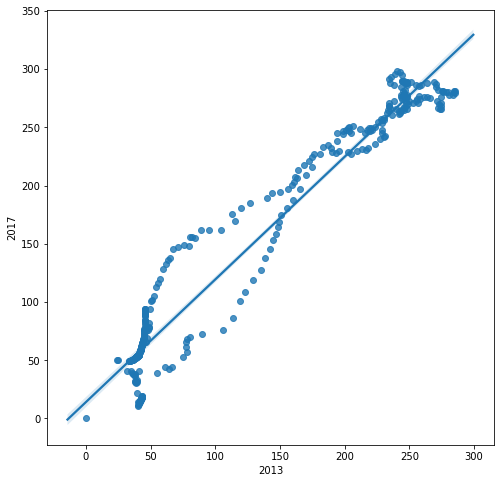

In [51]:
plt.figure(figsize=(8,8))
trout_reg = sns.regplot(x="2013", y="2017", data=analysis_dataset_train)
trout_reg

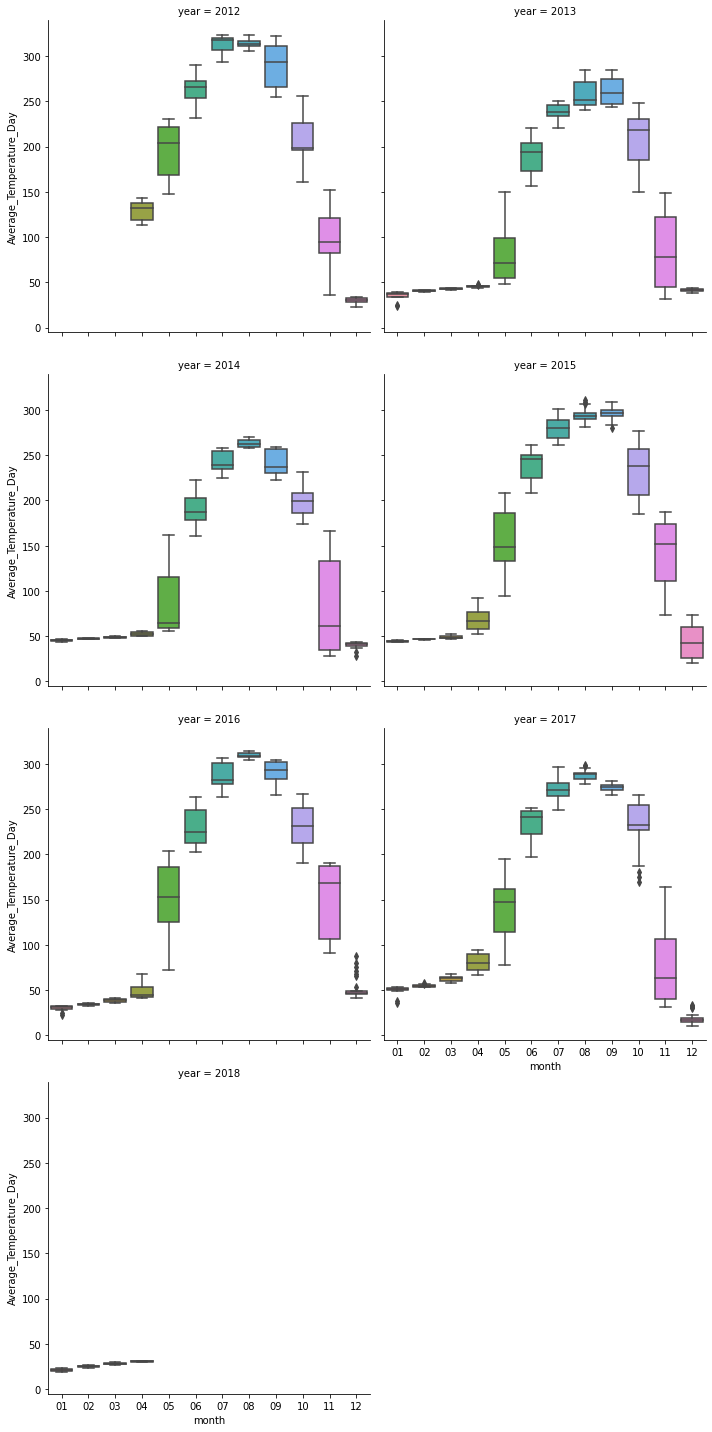

In [56]:
trout_boxplot = sns.catplot(x="month", y="Average_Temperature_Day",col="year", kind='box',col_wrap=2, data=trout_ready)
trout_boxplot

In [ ]:
# Splitting data and Running Algorithms

In [61]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error

def baseline_compare():  
    X, y = analysis_dataset_train.iloc[:,:7],analysis_dataset_train.iloc[:,-2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    lass_model = Lasso().fit(X_train, y_train)
    y_preds_lasso = lass_model.predict(X_test)
    lasso_train = lass_model.score(X_train, y_train)
    lasso_test = lass_model.score(X_test, y_test)
    print('Predictions:', y_preds_lasso)
    print('Training score: '+str(lasso_train))
    print('Testing score: '+str(lasso_test))
    mean_square_error = mean_squared_error(y_test, y_preds_lasso)
    print('Means Square Error:' + str(mean_square_error)) 
    
#     rid_model = Ridge().fit(X_train, y_train)
#     y_preds_rid = rid_model.predict(X_test)
#     rid_train = rid_model.score(X_train, y_train)
#     rid_test = rid_model.score(X_test, y_test)
#     print('Predictions:', y_preds_rid)
#     print('Training score: '+str(rid_train))
#     print('Testing score: '+str(rid_test))
#     mean_square_error = mean_squared_error(y_test, y_preds_rid)
#     print('Means Square Error:' + str(mean_square_error))    

baseline_compare()


Predictions: [290.16502931  49.43051952 206.08041959 147.56321847 266.40367019
  68.10037404 275.04468191  56.5270692   14.82233532  84.15524357
 285.50576831 266.0512195   49.90906603  53.12888736  54.19838178
  61.11939493  53.82855409 293.59255373  37.89238477 268.01115866
 265.68966091 138.04250426 247.08995937  53.79855465  54.37830162
  19.01125978 247.5154901   63.50302054 286.5354382  187.51953487
 287.16633683 295.96156006 100.8640621  180.49510134 232.52491092
  88.78221117 247.39024903 281.50488144  50.0890178  249.23973229
  72.85959748  54.49824266  52.8226304   49.48051387 120.06870614
  54.55822383  43.86714189  42.24758681  15.11228524 251.43953264
 248.0757428   39.10438459  13.03287494 265.91923946 278.02379261
 227.78860928 233.51445986 280.73502681 272.56698996 261.98656608
  61.12442625  50.84001477  74.98245026 291.09361185  61.67409338
  66.02157798 238.07228949 288.29418038  40.69625823 277.59177369
 254.52841986 256.33510455 288.10483443  53.98846958]
Training 

In [89]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

def mlp_reg():
    X, y = analysis_dataset_train.iloc[:,:7],analysis_dataset_train.iloc[:,-2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    mlp = MLPRegressor(random_state=1, max_iter=2000, activation='logistic', hidden_layer_sizes = (27,500), solver='adam')

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    mlp.fit(X_train_scaled, y_train)

    trainscore = mlp.score(X_train_scaled, y_train)
    testscore = mlp.score(X_test_scaled, y_test)
    print('Training score: '+str(trainscore))
    print('Testing score: '+str(testscore))

    y_preds = mlp.predict(X_test_scaled)

    print('Predictions:', y_preds)

    mean_square_error = mean_squared_error(y_test, y_preds)

    print('Means Square Error:' + str(mean_square_error))

mlp_reg()

Training score: 0.9955320619891905
Testing score: 0.9958562965383839
Predictions: [281.52287039  49.42934846 217.31053522 146.16608958 270.31451199
  68.53675951 275.80048608  59.39817047  27.31220886  70.97636686
 279.51082623 274.09406235  50.27354139  54.67386847  57.00598054
  59.9831142   56.13329293 281.94106797  36.86625868 275.06191196
 273.34029703 131.11579598 252.3434356   55.98290818  57.5631294
  28.52139334 257.12715804  64.61251342 279.86523368 186.8720448
 280.22100286 282.74726893  90.34148856 189.16466314 241.93568565
  73.52170862 253.04888578 280.10167413  49.36713291 255.09877783
  73.55082252  57.71888617  53.93150875  49.70009714 112.54661047
  57.96615461  48.71172848  46.78514616  27.36225677 256.88046477
 246.570667    38.46320949  26.71374962 263.62491842 277.50198944
 239.56068687 242.56024083 279.52751428 275.18971849 268.38685799
  63.05155233  51.1554336   66.82899296 281.09194515  63.31289057
  67.07787621 245.01567883 280.33180421  40.13868753 268.77471

C:\Users\tabas\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [64]:
def multiple_regress():
    X, y = analysis_dataset_train.iloc[:,:7],analysis_dataset_train.iloc[:,-2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    xg_reger = xgb.XGBRegressor(random_state=0, n_estimators = 50)

    xg_reger.fit(X_train_scaled,y_train)
    predict_xg = xg_reger.predict(X_test_scaled)
    xg_rmse = np.sqrt(mean_squared_error(y_test, predict_xg))
    
    ada_reger = AdaBoostRegressor(random_state=0, n_estimators=50)
    ada_reger.fit(X_train_scaled, y_train)
    predict_ada = ada_reger.predict(X_test_scaled)
    ada_rmse = np.sqrt(mean_squared_error(y_test, predict_ada))
    
    gra_reger = GradientBoostingRegressor(random_state=0, n_estimators=50)
    gra_reger.fit(X_train_scaled, y_train)
    predict_gra = gra_reger.predict(X_test_scaled)
    gra_rmse = np.sqrt(mean_squared_error(y_test, predict_gra))
   
    xg_score_train = xg_reger.score(X_train_scaled, y_train)
    xg_score_test = xg_reger.score(X_test_scaled, y_test)
    ada_score_train = ada_reger.score(X_train_scaled, y_train)
    ada_score_test = ada_reger.score(X_test_scaled, y_test)
    gra_score_train = gra_reger.score(X_train_scaled, y_train)
    gra_score_test = gra_reger.score(X_test_scaled, y_test)
    print('XGBoost_training score: '+str(xg_score_train))
    print('XGBoost_testing score: '+str(xg_score_test))
    print('XGBoost_Mean_Square_Error: '+str(xg_rmse))
    print('ADABoost_training score: '+str(ada_score_train))
    print('ADABoost_testing score: '+str(ada_score_test))
    print('ADAoost_Mean_Square_Error: '+str(ada_rmse))
    print('GRABoost_training score: '+str(gra_score_train))
    print('GRABoost_testing score: '+str(gra_score_test))
    print('GRABoost_Mean_Square_Error: '+str(gra_rmse))

multiple_regress()

XGBoost_training score: 0.9999916031226002
XGBoost_testing score: 0.9996075459019185
XGBoost_Mean_Square_Error: 2.0664285748795796
ADABoost_training score: 0.9985601397031949
ADABoost_testing score: 0.9986408823023821
ADAoost_Mean_Square_Error: 3.845514898809396
GRABoost_training score: 0.9999553205286806
GRABoost_testing score: 0.999896487604747
GRABoost_Mean_Square_Error: 1.0612608504937904


In [65]:
from sklearn.linear_model import LinearRegression

def linreg():
    X, y = analysis_dataset_train.iloc[:,:7],analysis_dataset_train.iloc[:,-2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    linreg_model = LinearRegression().fit(X_train_scaled, y_train)
    y_preds_linreg = linreg_model.predict(X_test_scaled)
    linreg_train = linreg_model.score(X_train_scaled, y_train)
    linreg_test = linreg_model.score(X_test_scaled, y_test)
    print('Training score: '+str(linreg_train))
    print('Testing score: '+str(linreg_test))
    mean_square_error = mean_squared_error(y_test, y_preds_linreg)
    print('Means Square Error:' + str(mean_square_error))

linreg()

Training score: 1.0
Testing score: 1.0
Means Square Error:1.93820992356302e-27


In [90]:
X, y = analysis_dataset_train.iloc[:,:7],analysis_dataset_train.iloc[:,-2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [91]:
print('Testing Label:', y_test)

Testing Label: date_month
04-08    290.18
04-01     49.43
04-06    206.08
16-05    147.55
07-07    266.41
          ...  
26-09    277.62
03-07    254.53
07-10    256.36
12-08    288.12
09-02     53.99
Name: 2017, Length: 74, dtype: float64


In [92]:
lass_model = Lasso().fit(X_train, y_train)
y_preds_lasso = lass_model.predict(X_test)
print('Predictions Lasso Model:', y_preds_lasso)

Predictions Lasso Model: [290.16502931  49.43051952 206.08041959 147.56321847 266.40367019
  68.10037404 275.04468191  56.5270692   14.82233532  84.15524357
 285.50576831 266.0512195   49.90906603  53.12888736  54.19838178
  61.11939493  53.82855409 293.59255373  37.89238477 268.01115866
 265.68966091 138.04250426 247.08995937  53.79855465  54.37830162
  19.01125978 247.5154901   63.50302054 286.5354382  187.51953487
 287.16633683 295.96156006 100.8640621  180.49510134 232.52491092
  88.78221117 247.39024903 281.50488144  50.0890178  249.23973229
  72.85959748  54.49824266  52.8226304   49.48051387 120.06870614
  54.55822383  43.86714189  42.24758681  15.11228524 251.43953264
 248.0757428   39.10438459  13.03287494 265.91923946 278.02379261
 227.78860928 233.51445986 280.73502681 272.56698996 261.98656608
  61.12442625  50.84001477  74.98245026 291.09361185  61.67409338
  66.02157798 238.07228949 288.29418038  40.69625823 277.59177369
 254.52841986 256.33510455 288.10483443  53.9884695

In [94]:
gra_reger = GradientBoostingRegressor(random_state=0, n_estimators=50)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
gra_reger.fit(X_train_scaled, y_train)
predict_gra = gra_reger.predict(X_test_scaled)
print('Predictions GRA Regressor Model:', predict_gra)

Predictions GRA Regressor Model: [288.50042947  49.23931294 207.45904269 147.97745108 266.90836394
  68.25206407 274.06845948  56.5621355   15.45832143  84.03221142
 285.41466432 266.95590824  50.64293347  53.58660069  54.48965363
  64.34200843  54.48965363 293.84466884  37.76237135 267.44253345
 264.29920326 138.38518818 246.47756092  54.04207195  54.92352436
  20.02256182 246.57844104  63.7152453  285.41466432 189.32928639
 286.02074725 293.84466884 100.69979131 181.15217637 232.01527614
  89.40118245 246.47756092 280.56607984  50.64293347 248.78865655
  72.05673217  54.97948769  51.43508887  50.64293347 118.97412118
  54.97948769  44.6224359   44.6224359   16.35877816 249.54584533
 246.55634348  40.7656314   13.75368574 264.04416464 277.10804559
 227.73413475 231.41599927 280.50513303 272.49518398 261.10651754
  62.21161119  51.37697346  74.96812192 288.50042947  62.21161119
  66.14958124 239.02323895 287.39621477  40.88523058 277.10804559
 254.05794263 255.43447696 287.39621477  54

In [ ]:
############################## Analysis_test_dataset below#########################################

In [ ]:
# test_dataset = trout_test_ready.copy()
# # analysis_dataset = dataset.rename(columns={"Date": "Time"})
# test_dataset['date_month'] = test_dataset['date'] + '-' + test_dataset['month']
# unique_test_years = list(test_dataset['year'].unique())
# analysis_test_dataset1 = test_dataset.drop(['month', 'date', 'Date'], axis = 1)
# for e in unique_test_years:
#     analysis_test_dataset1[e] = 0
# analysis_test_dataset2 = analysis_test_dataset1[['date_month', '2018', '2019']]
# analysis_test_dataset3 = analysis_test_dataset1[['year', 'date_month', 'Average_Temperature_Day']]
# analysis_test_dataset = analysis_test_dataset2.drop_duplicates().reset_index()
# del analysis_test_dataset['index']
# analysis_test_dataset

In [ ]:
# d_m_t = list(analysis_test_dataset['date_month'])
# list_list_test = []
# s = 2017

# while s < 2019:
#     test_per_list = []
#     s=s+1
#     tdf = analysis_test_dataset3[analysis_test_dataset3.year == str(s)]
#     for p in d_m_t:
#         df = tdf[ tdf['date_month'] == p ]
#         if len(df)!= 0:
#             temp_test = list(df['Average_Temperature_Day'])
#             test_per_list.append(temp[0]) 
#         else:
#             test_per_list.append(0)
#     list_list_test.append(test_per_list)

In [ ]:
# analysis_test_dataset['2018'] = list_list[0]
# analysis_test_dataset['2019'] = list_list[1]

In [ ]:
# dataset1 = analysis_dataset.loc[(analysis_dataset['date'] == '25') & (analysis_dataset['month'] == '03')]
# dataset_1 = dataset1.drop(['year', 'month', 'date'], axis = 1).set_index('Time')
# dataset2 = analysis_dataset.loc[(analysis_dataset['date'] == '12') & (analysis_dataset['month'] == '02')]
# dataset_2 = dataset2.drop(['year', 'month', 'date'], axis = 1).set_index('Time')
# dataset3 = analysis_dataset.loc[(analysis_dataset['date'] == '01') & (analysis_dataset['month'] == '01')]
# dataset_3 = dataset3.drop(['year', 'month', 'date'], axis = 1).set_index('Time')
# dataset4 = analysis_dataset.loc[(analysis_dataset['date'] == '30') & (analysis_dataset['month'] == '01')]
# dataset_4 = dataset4.drop(['year', 'month', 'date'], axis = 1).set_index('Time')
# dataset5 = analysis_dataset.loc[(analysis_dataset['date'] == '30') & (analysis_dataset['month'] == '02')]
# dataset_5 = dataset5.drop(['year', 'month', 'date'], axis = 1).set_index('Time')

In [ ]:
# for x in unique_depths:
# #     if x in trout_depth:
# #         ind = trout_depth.index(x)
# #         depth_list = trout_training[x]
# #         depth_list[ind] == trout_temp[ind]
# #         print(trout_training)
#     depth_data = trout_training[trout_training.Depth_m == x]
#     print(depth_data)
#     trout_training[x] = list(depth_data['Water_Temp_C'])

In [ ]:
# # p_data1 = trout_corr1.loc[(trout_corr1['Date'] == '23-05-2012')]
# # p_data2 = trout_corr1.loc[(trout_corr1['Date'] == '23-05-2016')]
# # del p_data1['date']
# # del p_data1['month']
# # del p_data1['year']
# # del p_data2['date']
# # del p_data2['month']
# # del p_data2['year']

# # p_data_1 = p_data1 = scat_data_1.set_index(['Date'])